In [1]:
!pip install -q segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.0 MB/s eta 0:00:00


In [149]:
import torch
import tqdm
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import seaborn as sns
import segmentation_models_pytorch as smp
from torch.nn.init import trunc_normal_
from sklearn.metrics import f1_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torchvision.models.vision_transformer import VisionTransformer
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from random import randint
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path

Вспомогательные функции

In [150]:
def item_show(img, label):
    np_img = img.numpy().astype(float)
    np_label = label.numpy().astype(float) * 256
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(np.transpose(np_img, (1, 2, 0)))
    axes[0].axis('off')
    axes[0].set_title('Изображение')
    axes[1].imshow(np_label, cmap='gray', vmin=0, vmax=1)
    axes[1].axis('off')
    axes[1].set_title('Маска')
    axes[2].imshow(np.transpose(np_img, (1, 2, 0)))
    axes[2].imshow(np_label, alpha=0.4, cmap='jet', vmin=0, vmax=1)
    axes[2].axis('off')
    axes[2].set_title('Наложение')
    plt.tight_layout()
    plt.show()

def get_accuracy(output, label) -> float:
    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def get_dice(output, label, smooth=1e-10, n_classes=2) -> float:
    with torch.no_grad():
        output = F.softmax(output, dim=1)
        output = torch.argmax(output, dim=1)
        output = output.contiguous().view(-1)
        label = label.contiguous().view(-1)

        dice_per_class = []

        for clas in range(n_classes):
            pred_class = output == clas
            true_class = label == clas

            if true_class.sum().item() == 0:
                dice_per_class.append(np.nan)
                continue

            intersect = torch.logical_and(pred_class, true_class).sum().item()
            total_pred = pred_class.sum().item()
            total_true = true_class.sum().item()

            dice = (2.0 * intersect + smooth) / (total_pred + total_true + smooth)
            dice_per_class.append(dice)

        return np.nanmean(dice_per_class)

Гиперпараметры

In [151]:
IMG_H = 512
IMG_W = 512
EPOCH_NUM = 25
BATCH_SIZE = 4
LR_RATE = 0.0001
GAMMA = 0.1

Загрузим датасет

In [152]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vpapenko/nails-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/nails-segmentation


Создадим класс для датасета

In [153]:
class NailsDataset(Dataset):
    def __init__(self, images_dir: str, labels_dir: str) -> None:
        self.classes = ("Background", "Nail")

        self._images_dir: Path = Path(images_dir)
        self._images: dict[str, Path] = {}
        self.image_transform = transforms.Compose([
            transforms.Resize((IMG_H, IMG_W)),
            transforms.ToTensor(),
        ])
        for file in self._images_dir.rglob("*"):
            self._images[file.stem] = file

        self._labels_dir: Path = Path(labels_dir)
        self._labels: dict[str, Path] = {}
        self.label_transform = transforms.Compose([
            transforms.Resize((IMG_H, IMG_W)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.squeeze(0)),
            transforms.Lambda(lambda x: torch.round(x)),
            transforms.Lambda(lambda x: (x * 1).type(torch.int64)),
        ])
        for file in self._labels_dir.rglob("*"):
            self._labels[file.stem] = file

    def __len__(self) -> int:
        return len(self._images)

    def __getitem__(self, idx) -> tuple:
        images = list(self._images.items())
        image = Image.open(images[idx][1]).convert("RGB")
        label = Image.open(self._labels[images[idx][0]]).convert("L")
        return self.image_transform(image), self.label_transform(label)

Разобьем данные и создадим на их основе загрузчики

train len:  42
test len:  10


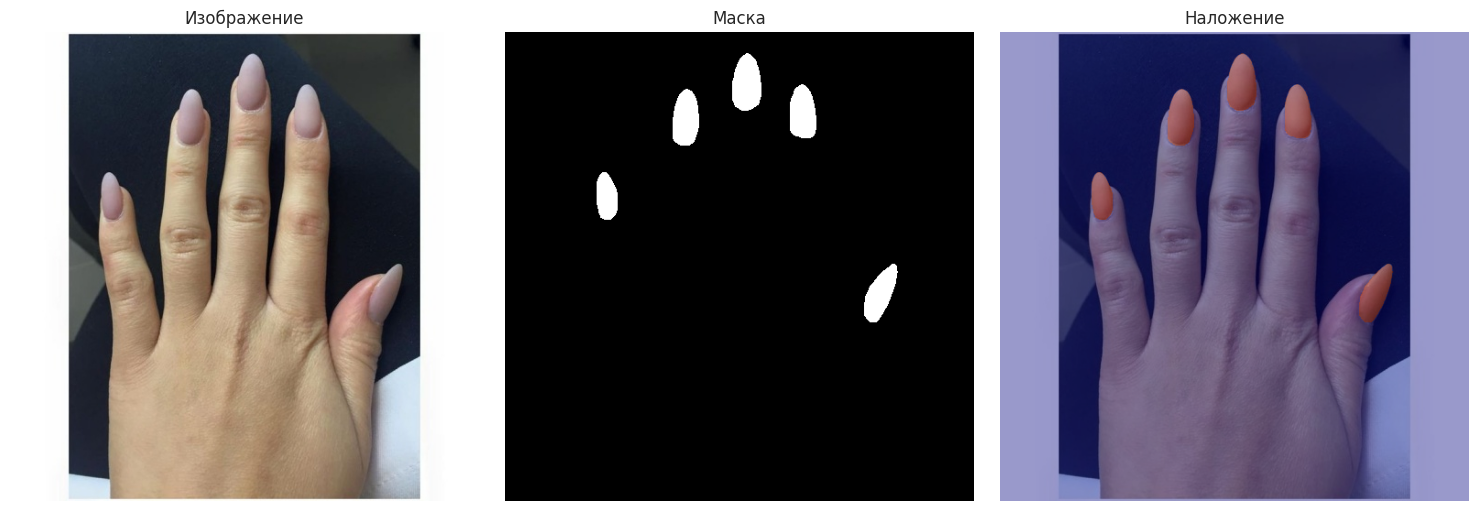

In [154]:
dataset = NailsDataset(f"{path}/nails_segmentation/images", f"{path}/nails_segmentation/labels")
train, test = random_split(dataset, [0.8, 0.2])
print("train len: ", len(train))
print("test len: ", len(test))

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE)

dataiter = iter(train_loader)
images, labels = next(dataiter)

item_show(images[0], labels[0])

Определим девайс на котором будем обучать

In [155]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Создадим функцию для обучения и подсчета метрик

In [156]:
def train_model(model, criterion, optimizer, epochs: int, n_print: int) -> tuple:
    train_accuracies = []
    train_dice_scores = []
    test_accuracies = []
    test_dice_scores = []
    for epoch in range(epochs):
        running_loss = 0
        accuracy = 0
        dice_score = 0
        for _, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            dice_score += get_dice(outputs, labels)
            accuracy += get_accuracy(outputs, labels)
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_accuracy = accuracy / len(train_loader)
        epoch_train_dice = dice_score / len(train_loader)
        train_accuracies.append(epoch_train_accuracy)
        train_dice_scores.append(epoch_train_dice)

        test_accuracy = 0
        test_dice_score = 0
        with torch.no_grad():
            for _, data in enumerate(test_loader):
                image_tiles, label_tiles = data
                image = image_tiles.to(device)
                label = label_tiles.to(device)
                outputs = model(image)
                test_dice_score += get_dice(outputs, label)
                test_accuracy += get_accuracy(outputs, label)
        epoch_test_accuracy = test_accuracy / len(test_loader)
        epoch_test_dice = test_dice_score / len(test_loader)
        test_accuracies.append(epoch_test_accuracy)
        test_dice_scores.append(epoch_test_dice)

        if (epoch + 1) % n_print == 0:
            print(f"Epoch {epoch + 1}:")
            print(f"\tTrain Loss: {epoch_train_loss:.4f}")
            print(f"\tTrain Accuracy: {epoch_train_accuracy:.4f}\t Train dice: {epoch_train_dice:.4f}")
            print(f"\tTest Accuracy:  {epoch_test_accuracy:.4f} \t Test dice:  {epoch_test_dice:.4f}")
            print()

    return (train_accuracies, train_dice_scores, test_accuracies, test_dice_scores)

In [160]:
def get_criterion_optimizer(model):
  optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)
  criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 4.0]).to(device))

  return criterion, optimizer

Определим и обучим сеть UNet

In [161]:
model_unet = smp.Unet("mobilenet_v2", encoder_weights="imagenet", classes=2)
model_unet = model_unet.to(device)
criterion, optimizer = get_criterion_optimizer(model_unet)

In [162]:
train_acc_unet, train_dice_unet, test_acc_unet, test_dice_unet = train_model(model_unet, criterion, optimizer, epochs=EPOCH_NUM, n_print=1)

Epoch 1:
	Train Loss: 1.9509
	Train Accuracy: 0.8320	 Train dice: 0.5524
	Test Accuracy:  0.8736 	 Test dice:  0.6414

Epoch 2:
	Train Loss: 1.5126
	Train Accuracy: 0.8947	 Train dice: 0.6725
	Test Accuracy:  0.9021 	 Test dice:  0.7036

Epoch 3:
	Train Loss: 1.2476
	Train Accuracy: 0.9141	 Train dice: 0.7140
	Test Accuracy:  0.9162 	 Test dice:  0.7331

Epoch 4:
	Train Loss: 1.0745
	Train Accuracy: 0.9310	 Train dice: 0.7523
	Test Accuracy:  0.9350 	 Test dice:  0.7689

Epoch 5:
	Train Loss: 0.9349
	Train Accuracy: 0.9459	 Train dice: 0.7796
	Test Accuracy:  0.9485 	 Test dice:  0.7995

Epoch 6:
	Train Loss: 0.8038
	Train Accuracy: 0.9645	 Train dice: 0.8329
	Test Accuracy:  0.9612 	 Test dice:  0.8326

Epoch 7:
	Train Loss: 0.7398
	Train Accuracy: 0.9644	 Train dice: 0.8225
	Test Accuracy:  0.9626 	 Test dice:  0.8394

Epoch 8:
	Train Loss: 0.6247
	Train Accuracy: 0.9699	 Train dice: 0.8478
	Test Accuracy:  0.9693 	 Test dice:  0.8574

Epoch 9:
	Train Loss: 0.5407
	Train Accuracy: 0.

Создадим функцию для вывода результатов работы

In [163]:
def predict(model, loader):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    predicted = model(images.to(device)).to("cpu")

    idx = randint(0, len(images) - 1)
    item_show(images[idx], labels[idx])
    item_show(images[idx], torch.argmax(predicted[idx], dim=0).detach())

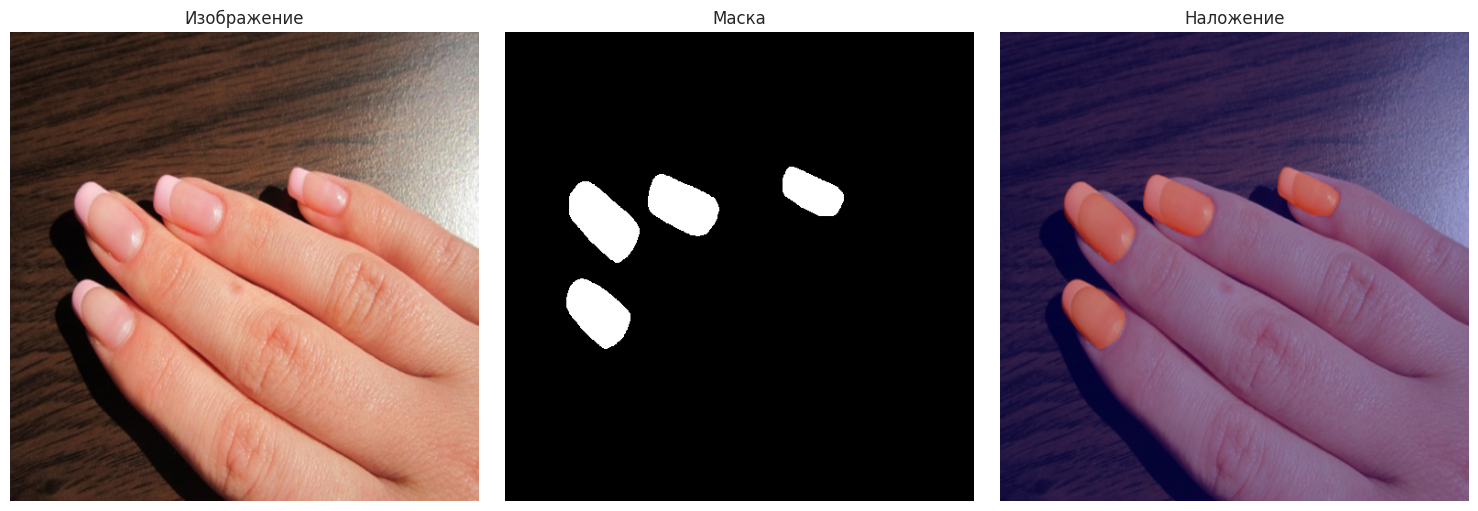

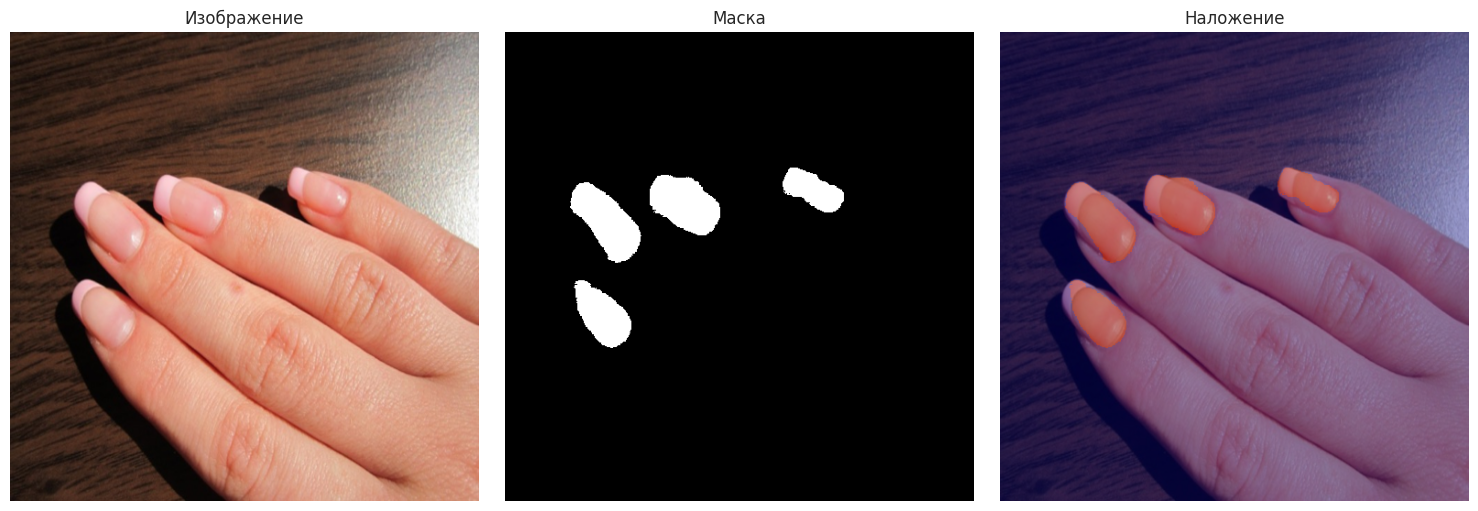

In [164]:
predict(model_unet, test_loader)

Определим кастомную модель

In [165]:
class TwoConvLayers(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.model(x)

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = TwoConvLayers(in_channels=in_channels, out_channels=out_channels)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.block(x)
        y = self.max_pool(x)
        return y, x

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.transpose = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2)
        self.block = TwoConvLayers(in_channels=in_channels, out_channels=out_channels)

    def forward(self, x, y):
        x = self.transpose(x)
        u = torch.cat([x, y], dim=1)
        u = self.block(u)
        return u

class Custom2Conv(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super().__init__()
        self.enc_block1 = Encoder(in_channels=in_channels, out_channels=64)
        self.enc_block2 = Encoder(in_channels=64, out_channels=128)
        self.enc_block3 = Encoder(in_channels=128, out_channels=256)
        self.enc_block4 = Encoder(in_channels=256, out_channels=512)

        self.bottleneck = TwoConvLayers(in_channels=512, out_channels=1024)

        self.dec_block1 = Decoder(in_channels=1024, out_channels=512)
        self.dec_block2 = Decoder(in_channels=512, out_channels=256)
        self.dec_block3 = Decoder(in_channels=256, out_channels=128)
        self.dec_block4 = Decoder(in_channels=128, out_channels=64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        x, y1 = self.enc_block1(x)
        x, y2 = self.enc_block2(x)
        x, y3 = self.enc_block3(x)
        x, y4 = self.enc_block4(x)

        x = self.bottleneck(x)

        x = self.dec_block1(x, y4)
        x = self.dec_block2(x, y3)
        x = self.dec_block3(x, y2)
        x = self.dec_block4(x, y1)

        return self.out(x)

In [166]:
model_custom_2conv = Custom2Conv().to(device)
criterion, optimizer = get_criterion_optimizer(model_custom_2conv)

In [167]:
train_acc_custom_2conv, train_dice_custom_2conv, test_acc_custom_2conv, test_dice_custom_2conv = train_model(model_custom_2conv, criterion, optimizer, epochs=EPOCH_NUM, n_print=1)

Epoch 1:
	Train Loss: 2.8472
	Train Accuracy: 0.4811	 Train dice: 0.3842
	Test Accuracy:  0.5482 	 Test dice:  0.4199

Epoch 2:
	Train Loss: 2.7008
	Train Accuracy: 0.5610	 Train dice: 0.4360
	Test Accuracy:  0.5905 	 Test dice:  0.4479

Epoch 3:
	Train Loss: 2.6691
	Train Accuracy: 0.5937	 Train dice: 0.4541
	Test Accuracy:  0.5960 	 Test dice:  0.4549

Epoch 4:
	Train Loss: 2.5789
	Train Accuracy: 0.6299	 Train dice: 0.4755
	Test Accuracy:  0.6637 	 Test dice:  0.5015

Epoch 5:
	Train Loss: 2.5490
	Train Accuracy: 0.6336	 Train dice: 0.4818
	Test Accuracy:  0.6888 	 Test dice:  0.5041

Epoch 6:
	Train Loss: 2.4769
	Train Accuracy: 0.7079	 Train dice: 0.5245
	Test Accuracy:  0.7255 	 Test dice:  0.5365

Epoch 7:
	Train Loss: 2.4080
	Train Accuracy: 0.7817	 Train dice: 0.5839
	Test Accuracy:  0.7607 	 Test dice:  0.5634

Epoch 8:
	Train Loss: 2.3545
	Train Accuracy: 0.7942	 Train dice: 0.5848
	Test Accuracy:  0.8148 	 Test dice:  0.6064

Epoch 9:
	Train Loss: 2.2118
	Train Accuracy: 0.

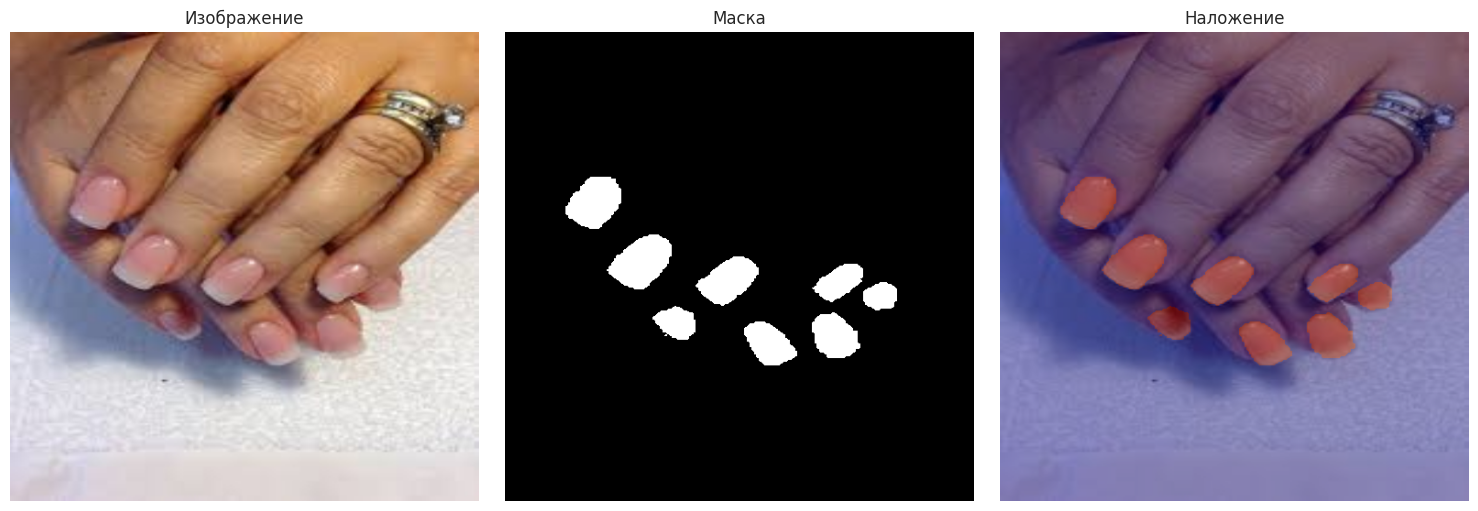

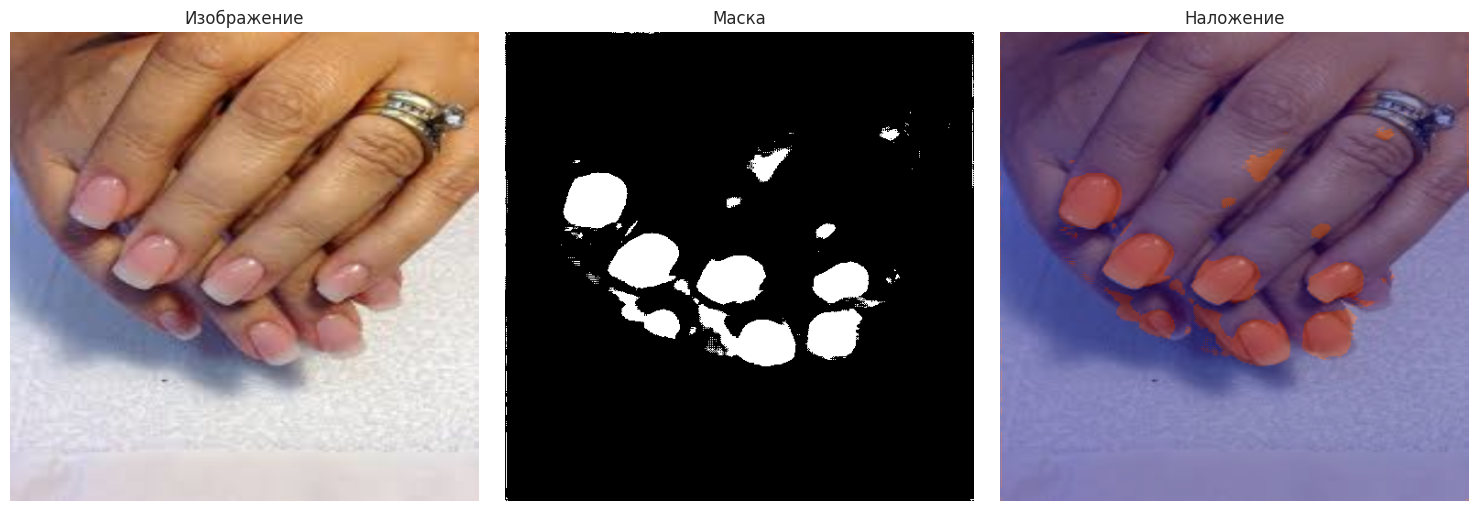

In [168]:
predict(model_custom_2conv, test_loader)

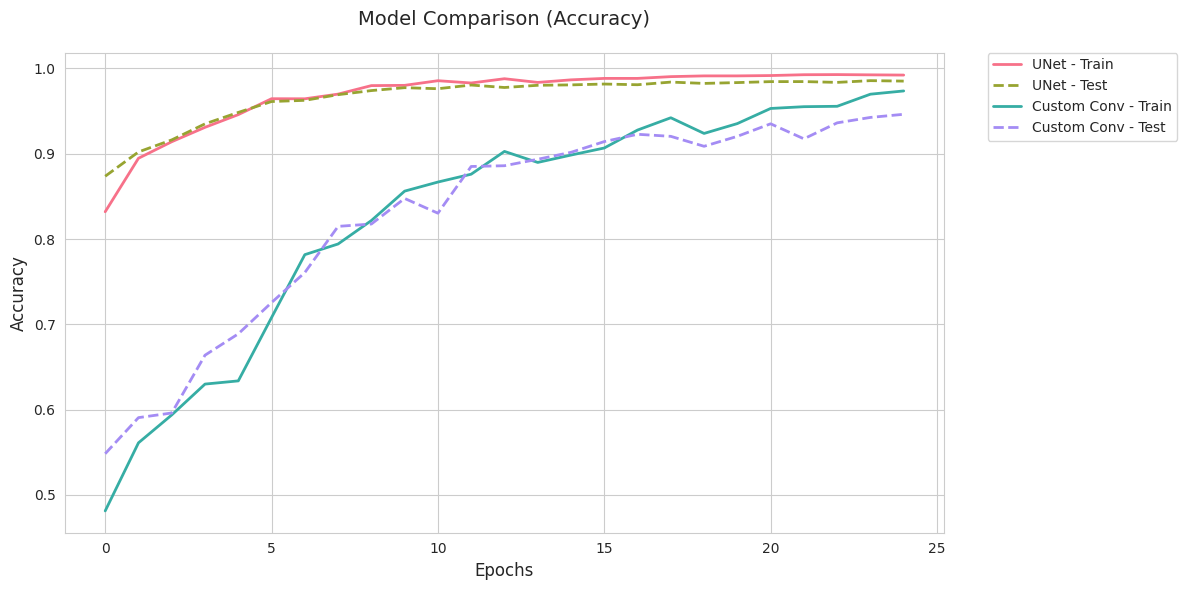

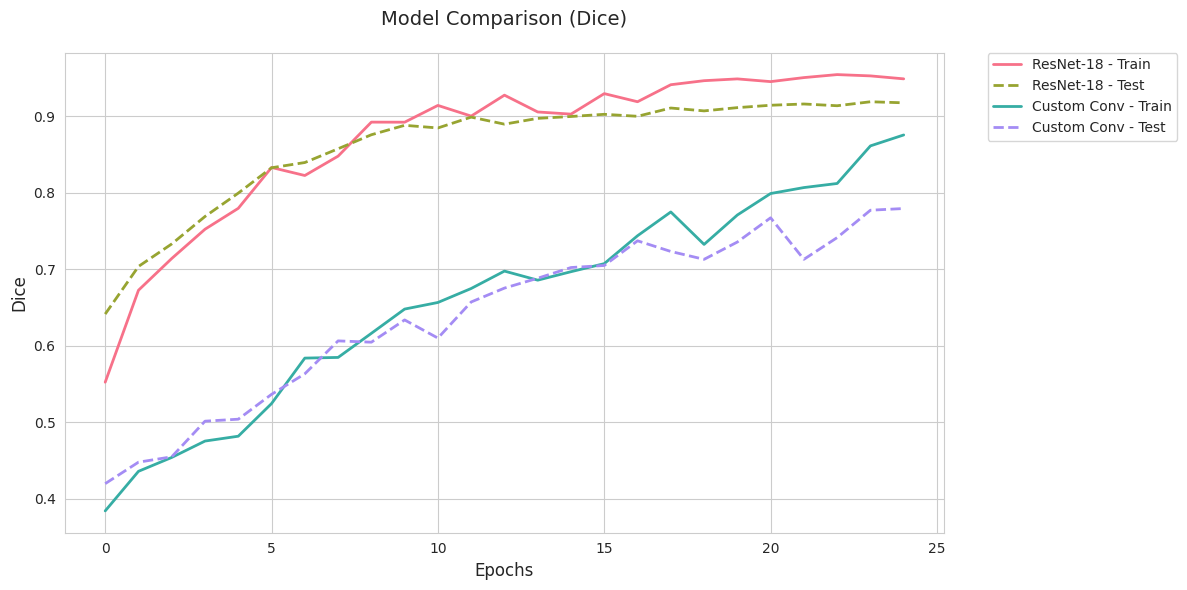

In [169]:
def show_metrics(metrics_dict, metric_name="Accuracy", title="Model Comparison"):
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    palette = sns.color_palette("husl", n_colors=len(metrics_dict)*2)

    for idx, (model_name, (train_metric, test_metric)) in enumerate(metrics_dict.items()):
        plt.plot(train_metric,
                 label=f'{model_name} - Train',
                 color=palette[idx*2],
                 linestyle='-',
                 linewidth=2)

        plt.plot(test_metric,
                 label=f'{model_name} - Test',
                 color=palette[idx*2+1],
                 linestyle='--',
                 linewidth=2)

    plt.title(f"{title} ({metric_name})", fontsize=14, pad=20)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

accuracy_data = {
    "UNet": (train_acc_unet, test_acc_unet),
    "Custom Conv": (train_acc_custom_2conv, test_acc_custom_2conv),
}
iou_data = {
    "ResNet-18": (train_dice_unet, test_dice_unet),
    "Custom Conv": (train_dice_custom_2conv, test_dice_custom_2conv),
}
show_metrics(accuracy_data, metric_name="Accuracy")
show_metrics(iou_data, metric_name="Dice")